In [1]:
import sys
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

sys.path.append("..")
import geoobb.obb as obb

In [2]:
from importlib import reload

In [3]:
reload(obb);

## Load Data


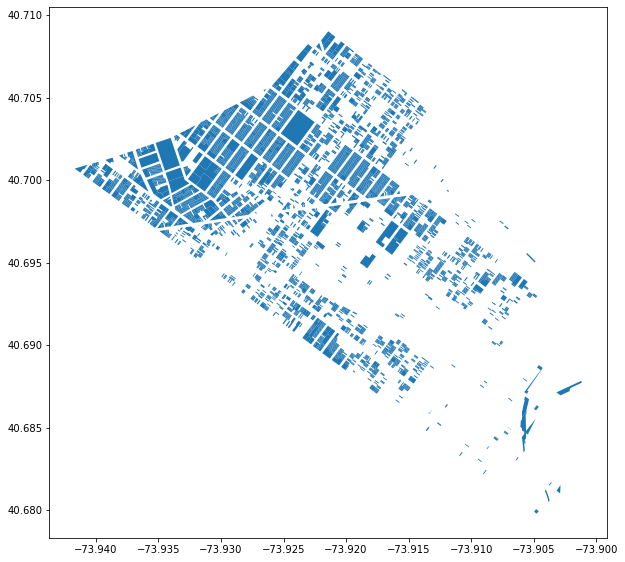

In [4]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson'
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)

gdf.plot(figsize=(10, 10));

In [5]:
# the api has a max record limit of 4000
len(gdf)

4000

In [6]:
gdf.to_crs(epsg=2263, inplace=True)

## Generate OBBs


In [8]:
%timeit gdf.geometry.map(obb.geom_to_array)

1 loop, best of 3: 186 ms per loop


In [9]:
geo_arrs = gdf.geometry.map(obb.geom_to_array)
%timeit geo_arrs.map(obb.oriented_bounding_box)

1 loop, best of 3: 346 ms per loop


In [10]:
geo_arrs = gdf.geometry.map(obb.geom_to_array)
%timeit geo_arrs.map(obb.oriented_bb_center_diff)

1 loop, best of 3: 268 ms per loop


Performance: pretty fast for 4,000 geometries!


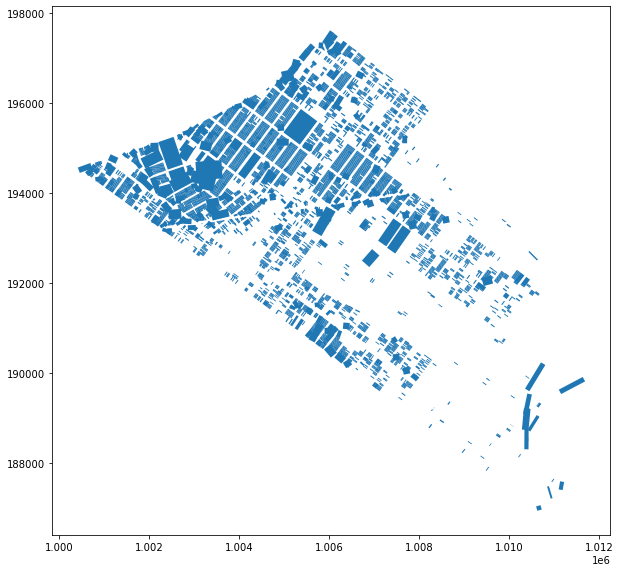

In [11]:
obbs = geo_arrs.map(obb.oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(Polygon))
obbs_gs.plot(figsize=(10, 10));

In [12]:
obbs_gs.crs = gdf.crs

#### Export and QC


In [ ]:
gdf.to_file('../data/gdf.shp')
obbs_gs.to_file('../data/obbs_2263.shp')

## Determine Parcel Orientions


In [13]:
def find_long_edge_and_angle(box):
    distances = [np.linalg.norm(box[i] - box[(i + 1) % 4]) for i in range(4)]
    long_edge_index = np.argmax(distances)
    p1, p2 = box[long_edge_index], box[(long_edge_index + 1) % 4]
    long_edge_vector = p2 - p1
    angle = np.arctan2(long_edge_vector[1], long_edge_vector[0])
    angle_degrees = np.degrees(angle)

    return long_edge_vector, angle_degrees


In [14]:
long_edges, angles = np.array([find_long_edge_and_angle(obb) for obb in obbs]).T

/Users/raphaellaude/opt/anaconda3/envs/sde_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


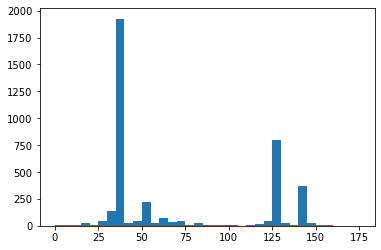

In [15]:
plt.hist(np.abs(angles), bins=np.arange(0, 180, 5));

In [16]:
absolute_angles = np.abs(angles)
np.median(absolute_angles), np.mean(absolute_angles)

(37.87261559738309, 70.52986277556263)

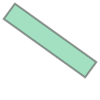

In [17]:
gdf.geometry.iloc[0]

In [18]:
x = obb.geom_to_array(gdf.geometry.iloc[0])

In [19]:
x

array([[1000833.30082355,  194573.71736532],
       [1000844.55080243,  194589.08053836],
       [1000915.22585064,  194514.99568983],
       [1000926.46174756,  194530.36901284]])

In [20]:
ca = np.cov(x, y=None, rowvar=False, bias=True)

val, vect = np.linalg.eig(ca)
tvect = np.transpose(vect)

#use the inverse of the eigenvectors as a rotation matrix and
#rotate the points so they align with the x and y axes
arr = np.dot(x, np.linalg.inv(tvect))

In [23]:
# get the minimum and maximum x and y
mina = np.min(arr, axis=0)
maxa = np.max(arr, axis=0)
diff = (maxa - mina) * 0.5

# the center is just half way between the min and max xy
center = mina + diff

#get the 4 corners by subtracting and adding half the bounding boxes height and width to the center
a, b = diff
corners = np.array([
    center + [-a, -b], center + [a, -b], center + [a, b], center + [-a, b],
    center + [-a, -b]
])

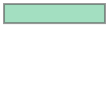

In [24]:
Polygon(corners)

In [25]:
def transform_geom_coords(geom, transfm_matrix):
    geom_arr = obb.geom_to_array(geom)
    arr = np.dot(geom_arr, transfm_matrix)
    mina = np.min(arr, axis=0)
    maxa = np.max(arr, axis=0)
    diff = (maxa - mina) * 0.5

    # the center is just half way between the min and max xy
    center = mina + diff

    #get the 4 corners by subtracting and adding half the bounding boxes height and width to the center
    a, b = diff
    return Polygon((
        center + [-a, -b], center + [a, -b], center + [a, b], center + [-a, b],
        center + [-a, -b]
    ))

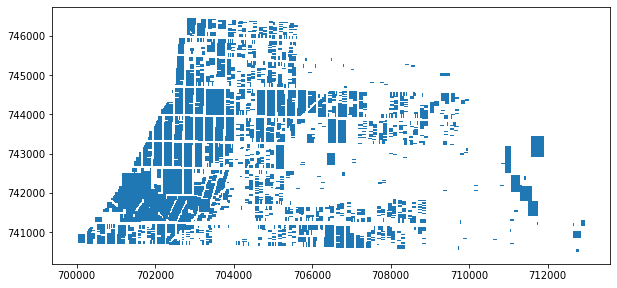

In [26]:
tx = np.linalg.inv(tvect)

rot_geos = gdf.geometry.map(lambda g: transform_geom_coords(g, tx))
rot_geos.crs = gdf.crs

rot_geos.plot(figsize=(10, 10));

In [ ]:
rot_geos.to_file('../data/rot_geos.shp')